In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [2]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch

# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

In [3]:
from platform import python_version
import sklearn
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.4
pandas==0.25.1
numpy==1.16.5
sklearn==0.21.3
torch==1.3.1
matplotlib==3.1.1


# Long Short-Term Memory

In [4]:
# Import additional libs
import warnings
import itertools
import statsmodels.api as sm

### Load Data

In [5]:
# Load the data
df = pd.read_csv('avocado.csv')
cols = df.columns

In [7]:
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


#### Select Timeseries

In [6]:
region = 'TotalUS'
Type = 'conventional'

In [69]:
df_sub = df.loc[ (df.region == region) & (df.type == Type)]

# keep only price and dates
keepcols = ['Date', 'AveragePrice', 'Total Volume']#, '4046','4225', '4770', 'Total Bags']
ts = df_sub[keepcols]

In [70]:
ts = ts.sort_values('Date')
ts

,Date,AveragePrice,Total Volume
2703,2015-01-04,0.95,31324277.73
2702,2015-01-11,1.01,29063542.75
2701,2015-01-18,1.03,29043458.85
2700,2015-01-25,1.04,28470310.84
2699,2015-02-01,0.89,44655461.51
...,...,...,...
9094,2018-02-25,1.06,40021528.76
9093,2018-03-04,1.07,40741214.05
9092,2018-03-11,1.09,40449603.12
9091,2018-03-18,1.05,41386314.12


In [71]:
ts.index = ts.Date
ts = ts.drop(['Date'], axis=1)
ts

,AveragePrice,Total Volume
Date,,
2015-01-04,0.95,31324277.73
2015-01-11,1.01,29063542.75
2015-01-18,1.03,29043458.85
2015-01-25,1.04,28470310.84
2015-02-01,0.89,44655461.51
...,...,...
2018-02-25,1.06,40021528.76
2018-03-04,1.07,40741214.05
2018-03-11,1.09,40449603.12


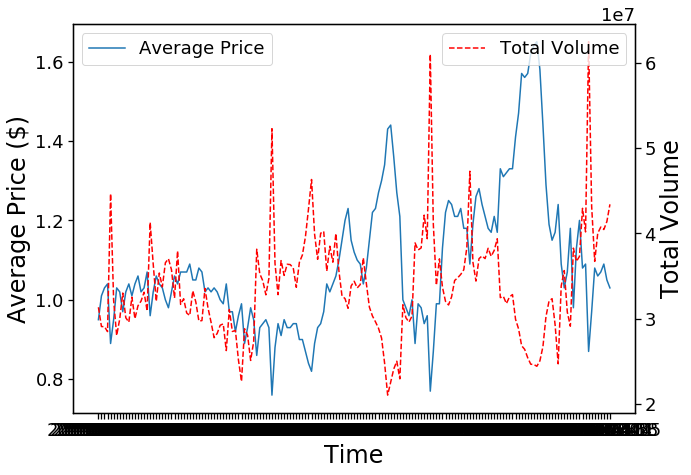

In [72]:
#plot
fig, ax = plt.subplots()
ax.plot(ts.index, ts.AveragePrice, label= 'Average Price')
ax2 = ax.twinx()
ax2.plot(ts.index, ts['Total Volume'], 'r--', label='Total Volume')
ax.set_xlabel('Time')
ax.set_ylabel('Average Price ($)')
ax2.set_ylabel('Total Volume')
ax.legend()
ax2.legend(loc=1)

### Train test split

In [73]:
test_data_size = 13

train_data = ts[:-test_data_size]
test_data = ts[-test_data_size:]

In [74]:
train_data

,AveragePrice,Total Volume
Date,,
2015-01-04,0.95,31324277.73
2015-01-11,1.01,29063542.75
2015-01-18,1.03,29043458.85
2015-01-25,1.04,28470310.84
2015-02-01,0.89,44655461.51
...,...,...
2017-11-26,1.24,24686675.00
2017-12-03,1.09,33824253.00
2017-12-10,1.03,35634913.01


### Scale data

In [75]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)

In [76]:
train_data_normalized

array([[-0.57303371, -0.48459124],
       [-0.43820225, -0.59755815],
       [-0.39325843, -0.59856173],
       [-0.37078652, -0.62720142],
       [-0.70786517,  0.18155616],
       [-0.57303371, -0.44396359],
       [-0.39325843, -0.65007678],
       [-0.41573034, -0.55392577],
       [-0.52808989, -0.40115599],
       [-0.41573034, -0.5460322 ],
       [-0.37078652, -0.57213972],
       [-0.43820225, -0.42516433],
       [-0.37078652, -0.55163126],
       [-0.3258427 , -0.4757771 ],
       [-0.41573034, -0.44850735],
       [-0.39325843, -0.39629689],
       [-0.30337079, -0.50608395],
       [-0.5505618 ,  0.01347221],
       [-0.41573034, -0.23091761],
       [-0.3258427 , -0.44944254],
       [-0.37078652, -0.28372014],
       [-0.39325843, -0.36487118],
       [-0.46067416, -0.22346676],
       [-0.50561798, -0.19967696],
       [-0.41573034, -0.26421066],
       [-0.3258427 , -0.43040333],
       [-0.37078652, -0.15382607],
       [-0.30337079, -0.46781391],
       [-0.30337079,

### Create sequences

In [77]:
N = len(keepcols)-1
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1,N)

In [78]:
train_window = 12

In [79]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [80]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [81]:
train_inout_seq

[(tensor([[-0.5730, -0.4846],
          [-0.4382, -0.5976],
          [-0.3933, -0.5986],
          [-0.3708, -0.6272],
          [-0.7079,  0.1816],
          [-0.5730, -0.4440],
          [-0.3933, -0.6501],
          [-0.4157, -0.5539],
          [-0.5281, -0.4012],
          [-0.4157, -0.5460],
          [-0.3708, -0.5721],
          [-0.4382, -0.4252]]), tensor([[-0.3708, -0.5516]])),
 (tensor([[-0.4382, -0.5976],
          [-0.3933, -0.5986],
          [-0.3708, -0.6272],
          [-0.7079,  0.1816],
          [-0.5730, -0.4440],
          [-0.3933, -0.6501],
          [-0.4157, -0.5539],
          [-0.5281, -0.4012],
          [-0.4157, -0.5460],
          [-0.3708, -0.5721],
          [-0.4382, -0.4252],
          [-0.3708, -0.5516]]), tensor([[-0.3258, -0.4758]])),
 (tensor([[-0.3933, -0.5986],
          [-0.3708, -0.6272],
          [-0.7079,  0.1816],
          [-0.5730, -0.4440],
          [-0.3933, -0.6501],
          [-0.4157, -0.5539],
          [-0.5281, -0.4012],
    

### Model

In [82]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size=N, hidden_layer_size=100, output_size=N):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), 1, -1))
        return predictions[-1]

In [83]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [84]:
print(model)

LSTM(
  (lstm): LSTM(2, 100)
  (linear): Linear(in_features=100, out_features=2, bias=True)
)


### Training the model

In [85]:
epochs = 750

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.07005101
epoch:  26 loss: 0.05067471
epoch:  51 loss: 0.02073386
epoch:  76 loss: 0.00383785
epoch: 101 loss: 0.00869822
epoch: 126 loss: 0.00158487
epoch: 151 loss: 0.00220060
epoch: 176 loss: 0.00003469
epoch: 201 loss: 0.00043663
epoch: 226 loss: 0.00057627
epoch: 251 loss: 0.00012059
epoch: 276 loss: 0.00066792
epoch: 301 loss: 0.00200055
epoch: 326 loss: 0.00039693
epoch: 351 loss: 0.00329254
epoch: 376 loss: 0.00312275
epoch: 401 loss: 0.00008742
epoch: 426 loss: 0.00133215
epoch: 451 loss: 0.00116835
epoch: 476 loss: 0.00170731
epoch: 501 loss: 0.00042287
epoch: 526 loss: 0.00025673
epoch: 551 loss: 0.00141979
epoch: 576 loss: 0.00081783
epoch: 601 loss: 0.00091223
epoch: 626 loss: 0.00013797
epoch: 651 loss: 0.00069718
epoch: 676 loss: 0.00071769
epoch: 701 loss: 0.00124271
epoch: 726 loss: 0.00139721
epoch: 749 loss: 0.0011612598


### Making predictions

In [86]:
del test_inputs

In [87]:
fut_pred = 13

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[[1.0, -0.8307328224182129], [0.8426966071128845, -0.7990313172340393], [0.5280898809432983, -0.7153139114379883], [0.1910112351179123, -0.5388759970664978], [-0.033707864582538605, -0.44824787974357605], [-0.12359550595283508, -0.4340251386165619], [-0.07865168899297714, -0.5880669355392456], [0.07865168899297714, -0.8162663578987122], [-0.2584269642829895, -0.35966968536376953], [-0.3932584226131439, -0.269192636013031], [-0.30337077379226685, -0.5128992795944214], [-0.056179776787757874, -0.5956190228462219]]


In [88]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).flatten().tolist())

In [89]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, N))
print(actual_predictions)

x = np.arange(156, 169, 1)

[[1.09422369e+00 3.48276521e+07]
 [1.09327729e+00 3.22873158e+07]
 [1.10165143e+00 3.05646596e+07]
 [1.16438761e+00 2.71138459e+07]
 [1.13347011e+00 2.88008222e+07]
 [1.11256719e+00 2.96552402e+07]
 [1.07443073e+00 2.97691412e+07]
 [1.06016529e+00 2.76565000e+07]
 [1.01584248e+00 2.94012760e+07]
 [9.66391695e-01 3.03888997e+07]
 [9.71586540e-01 2.78885889e+07]
 [9.70839596e-01 2.69796216e+07]
 [8.82852370e-01 3.46337600e+07]]


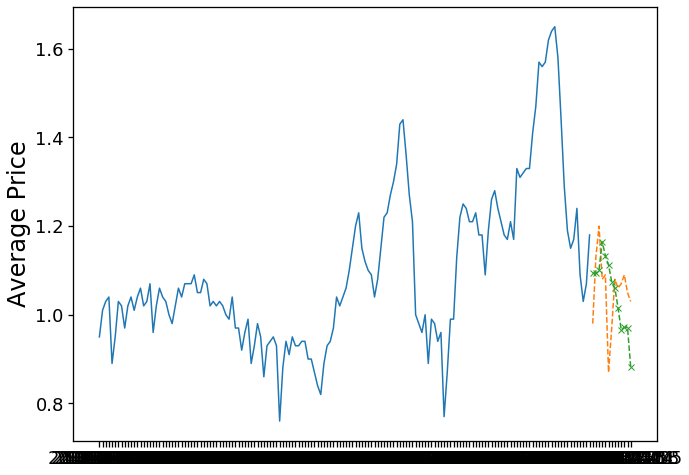

In [90]:
plt.ylabel('Average Price')
#plt.autoscale(axis='x', tight=True)
plt.plot(train_data.AveragePrice)
plt.plot(test_data.AveragePrice, '--')
plt.plot(x,actual_predictions[:,0], 'x--')
plt.show()

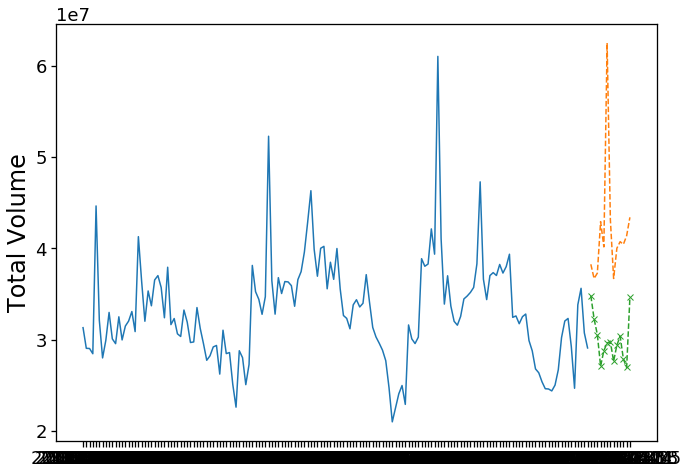

In [91]:
plt.ylabel('Total Volume')
#plt.autoscale(axis='x', tight=True)
plt.plot(train_data['Total Volume'])
plt.plot(test_data['Total Volume'], '--')
plt.plot(x,actual_predictions[:,1], 'x--' )
plt.show()

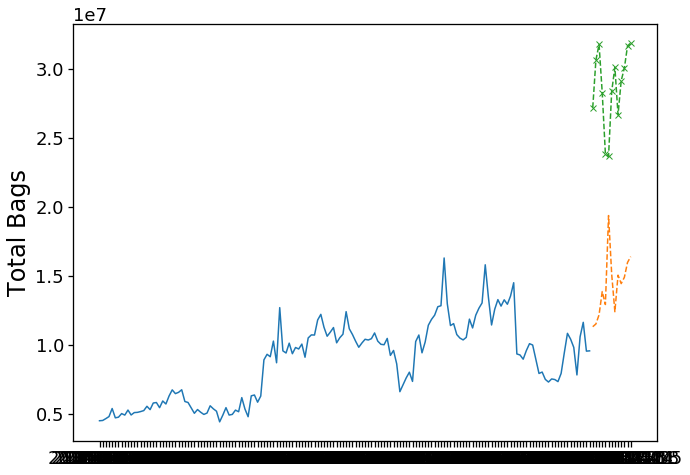

In [42]:
plt.ylabel('Total Bags')
#plt.autoscale(axis='x', tight=True)
plt.plot(train_data['Total Bags'])
plt.plot(test_data['Total Bags'], '--')
plt.plot(x,actual_predictions[:,1], 'x--' )
plt.show()

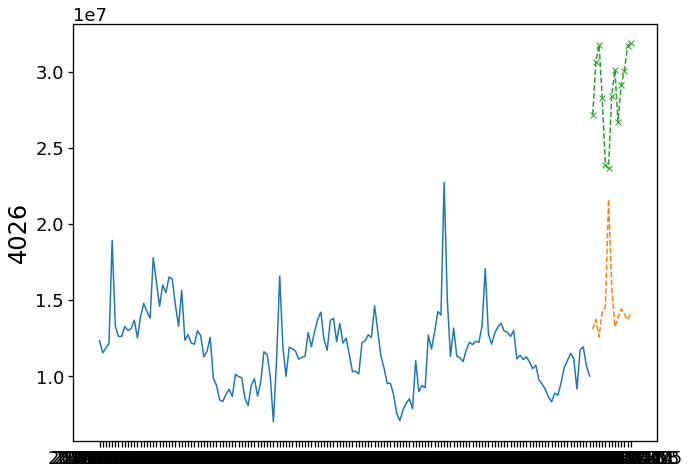

In [44]:
plt.ylabel('4046')
#plt.autoscale(axis='x', tight=True)
plt.plot(train_data['4046'])
plt.plot(test_data['4046'], '--')
plt.plot(x,actual_predictions[:,1], 'x--' )
plt.show()

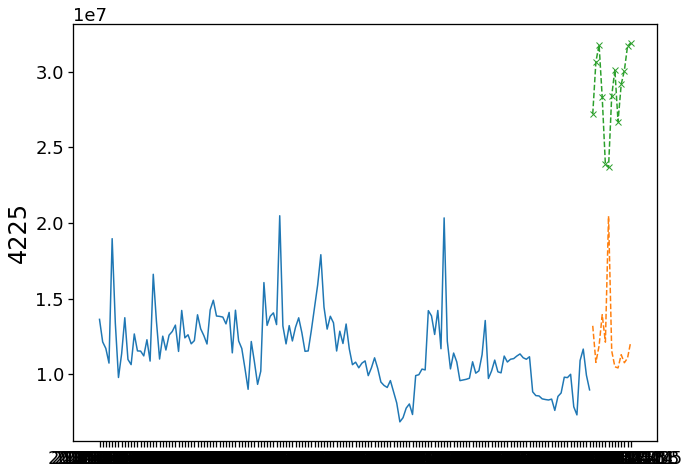

In [45]:
plt.ylabel('4225')
#plt.autoscale(axis='x', tight=True)
plt.plot(train_data['4225'])
plt.plot(test_data['4225'], '--')
plt.plot(x,actual_predictions[:,1], 'x--' )
plt.show()

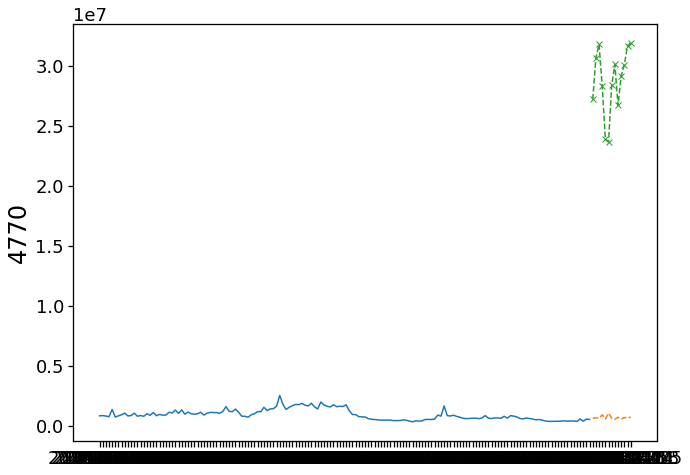

In [46]:
plt.ylabel('4770')
#plt.autoscale(axis='x', tight=True)
plt.plot(train_data['4770'])
plt.plot(test_data['4770'], '--')
plt.plot(x,actual_predictions[:,1], 'x--' )
plt.show()